# A Bayesian view

## Overview

* Variational formulations
* A probabilistic view and Bayes' Law
* Modelling tools

# Variational formulations


We've seen Tikhonov

$$\min_u \|Ku - f\|_2^2 + \alpha \|u\|_2^2,$$

which we can generalise to

$$\min_u \|Ku - f\|_2^2 + \alpha \|Lu\|_2^2.$$

Other norms are popular as well:

$$\min_u \|Ku - f\|_2^2 + \alpha \|u\|_1,$$

or

$$\min_u \|Ku - f\|_2^2 + \alpha \|Lu\|_1$$


We can even use different data-fidelity terms

$$\min_u \|W(Ku - f)\|_2^2 + \alpha \|u\|_2^2,$$

or, in general,

$$\min_u \mathcal{L}(Ku, f) + \alpha \mathcal{R}(u).$$


# A probabilistic view and Bayes' Law



Consider a stochastic description of the measurement process, with probability density

$$\pi_{\text{like}}(f | u),$$

and a probability distribution encoding prior knowledge on $u$

$$\pi_{\text{prior}}(u).$$

The *posterior* distribution describes a probability distribution over $u$, conditioned on given measurements $f$:

$$\pi_{\text{post}}(u | f) \propto \pi_{\text{like}}(f | u)\pi_{\text{prior}}(u).$$

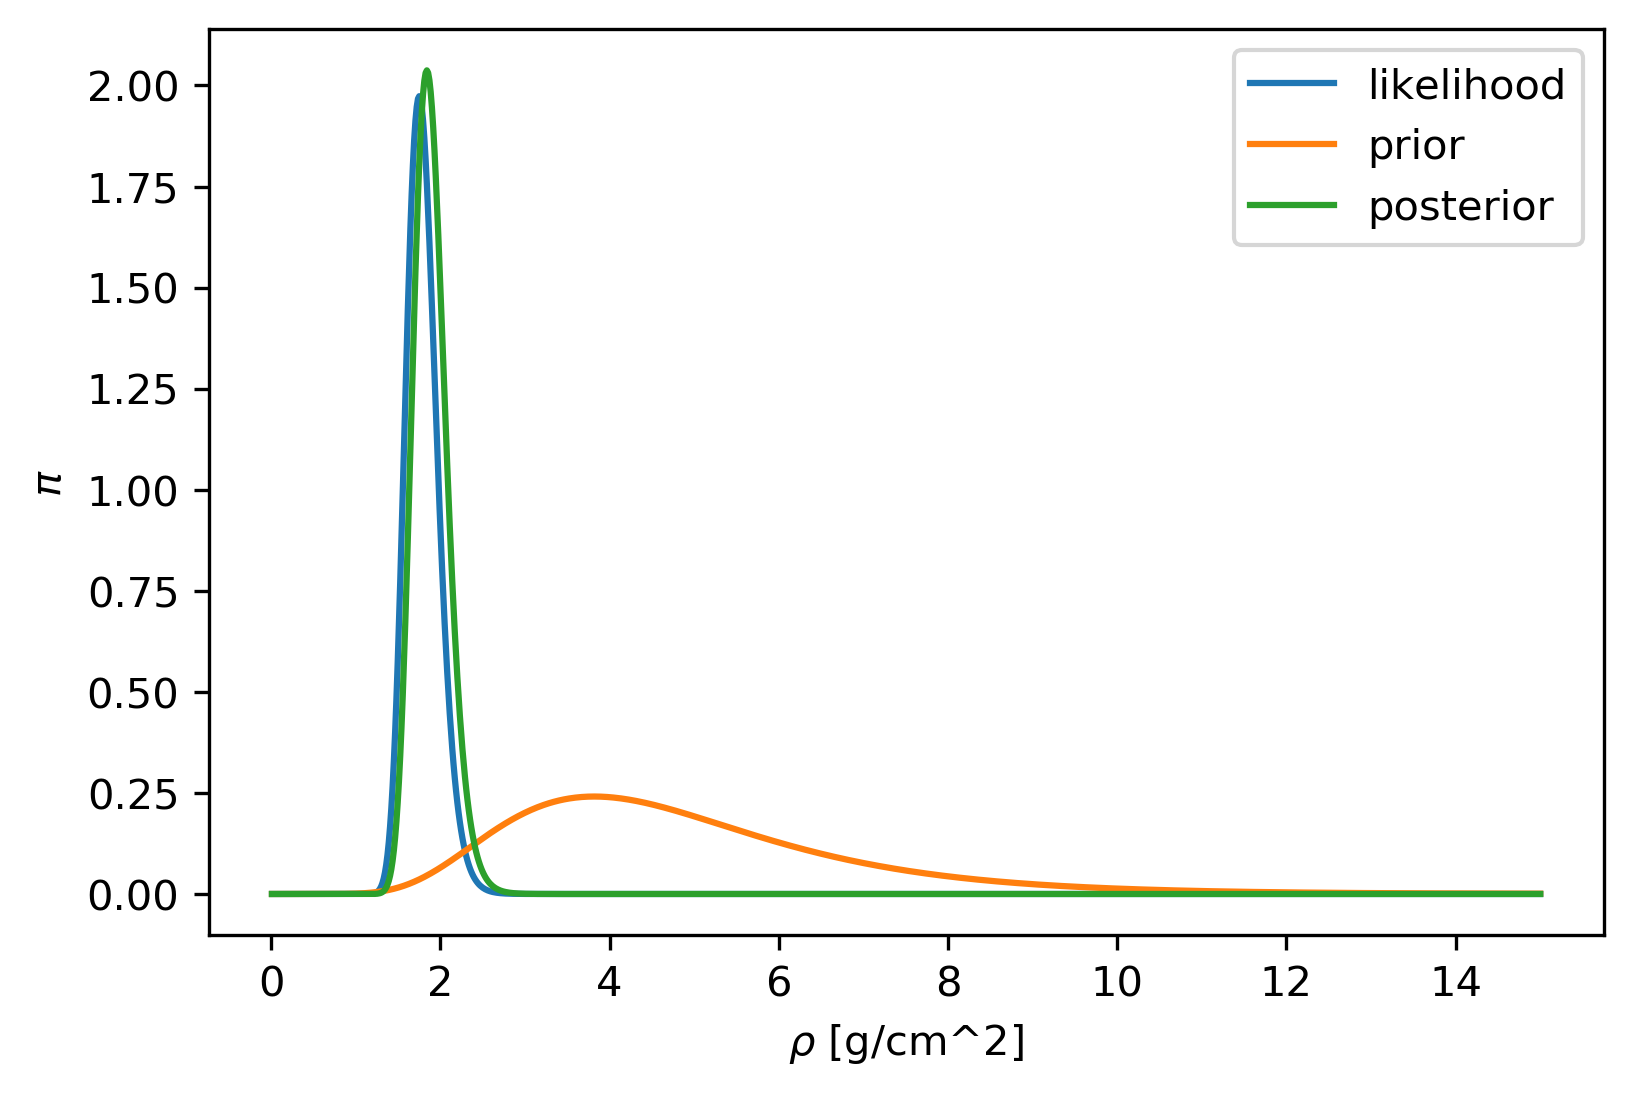

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# parameters
mu_prior = 1.5
sigma_prior = 0.4
sigma = 1e-1

# data
w = 2
v = 1
w_delta = w + np.random.normal(0,sigma)
v_delta = v + np.random.normal(0,sigma)

#
rho = np.linspace(0.01,15,1000)

likelihood = np.exp(-(w_delta - rho*v_delta)**2/(2*(1+rho**2)*sigma**2))/(sigma*np.sqrt(1+rho**2)*np.sqrt(2*np.pi))
prior = np.exp(-(np.log(rho)-mu_prior)**2/(2*sigma_prior**2))/(rho*sigma_prior*np.sqrt(2*np.pi))

# plot
fig,ax = plt.subplots(1,1)

ax.plot(rho,likelihood,label='likelihood')
ax.plot(rho,prior,label='prior')
ax.plot(rho,likelihood*prior/np.sum(likelihood*prior)*np.sum(prior),label='posterior')
ax.set_xlabel(r'$\rho$ [g/cm^2]')
ax.set_ylabel(r'$\pi$')
ax.legend()

plt.savefig('rock.png',dpi=300)

Estimate density of rock sample $\rho = w/v$ [g/cm^3] from measurements of weight $w$ and volume $v$:

* Assume $w^\delta = w + \epsilon_{w}$ and $v^\delta = v + \epsilon_{v}$, where $\epsilon_w,\epsilon_v$ are normally distributed with mean zero and variance $\sigma^2$
* We have $w^\delta - \rho v^\delta = \epsilon_w - \rho \epsilon_v$
* Thus, $w^\delta - \rho v^\delta$ is a normally distributed random variable with mean zero and variance $\sigma^2(1 + \rho^2)$

This gives us the following Likelihood

$$\pi_{\text{data}}(u | f^\delta) = \frac{1}{\sigma\sqrt{1+\rho^2}\sqrt{2\pi}}\exp\left(-\frac{(w^\delta - \rho v^\delta)^2}{2\sigma^2(1+\rho^2)}\right).$$

As prior, we can use statistics of rock samples, which is a log-normal disrtibution with parameters $(1.5,0.4)$. 

![](rock.png)

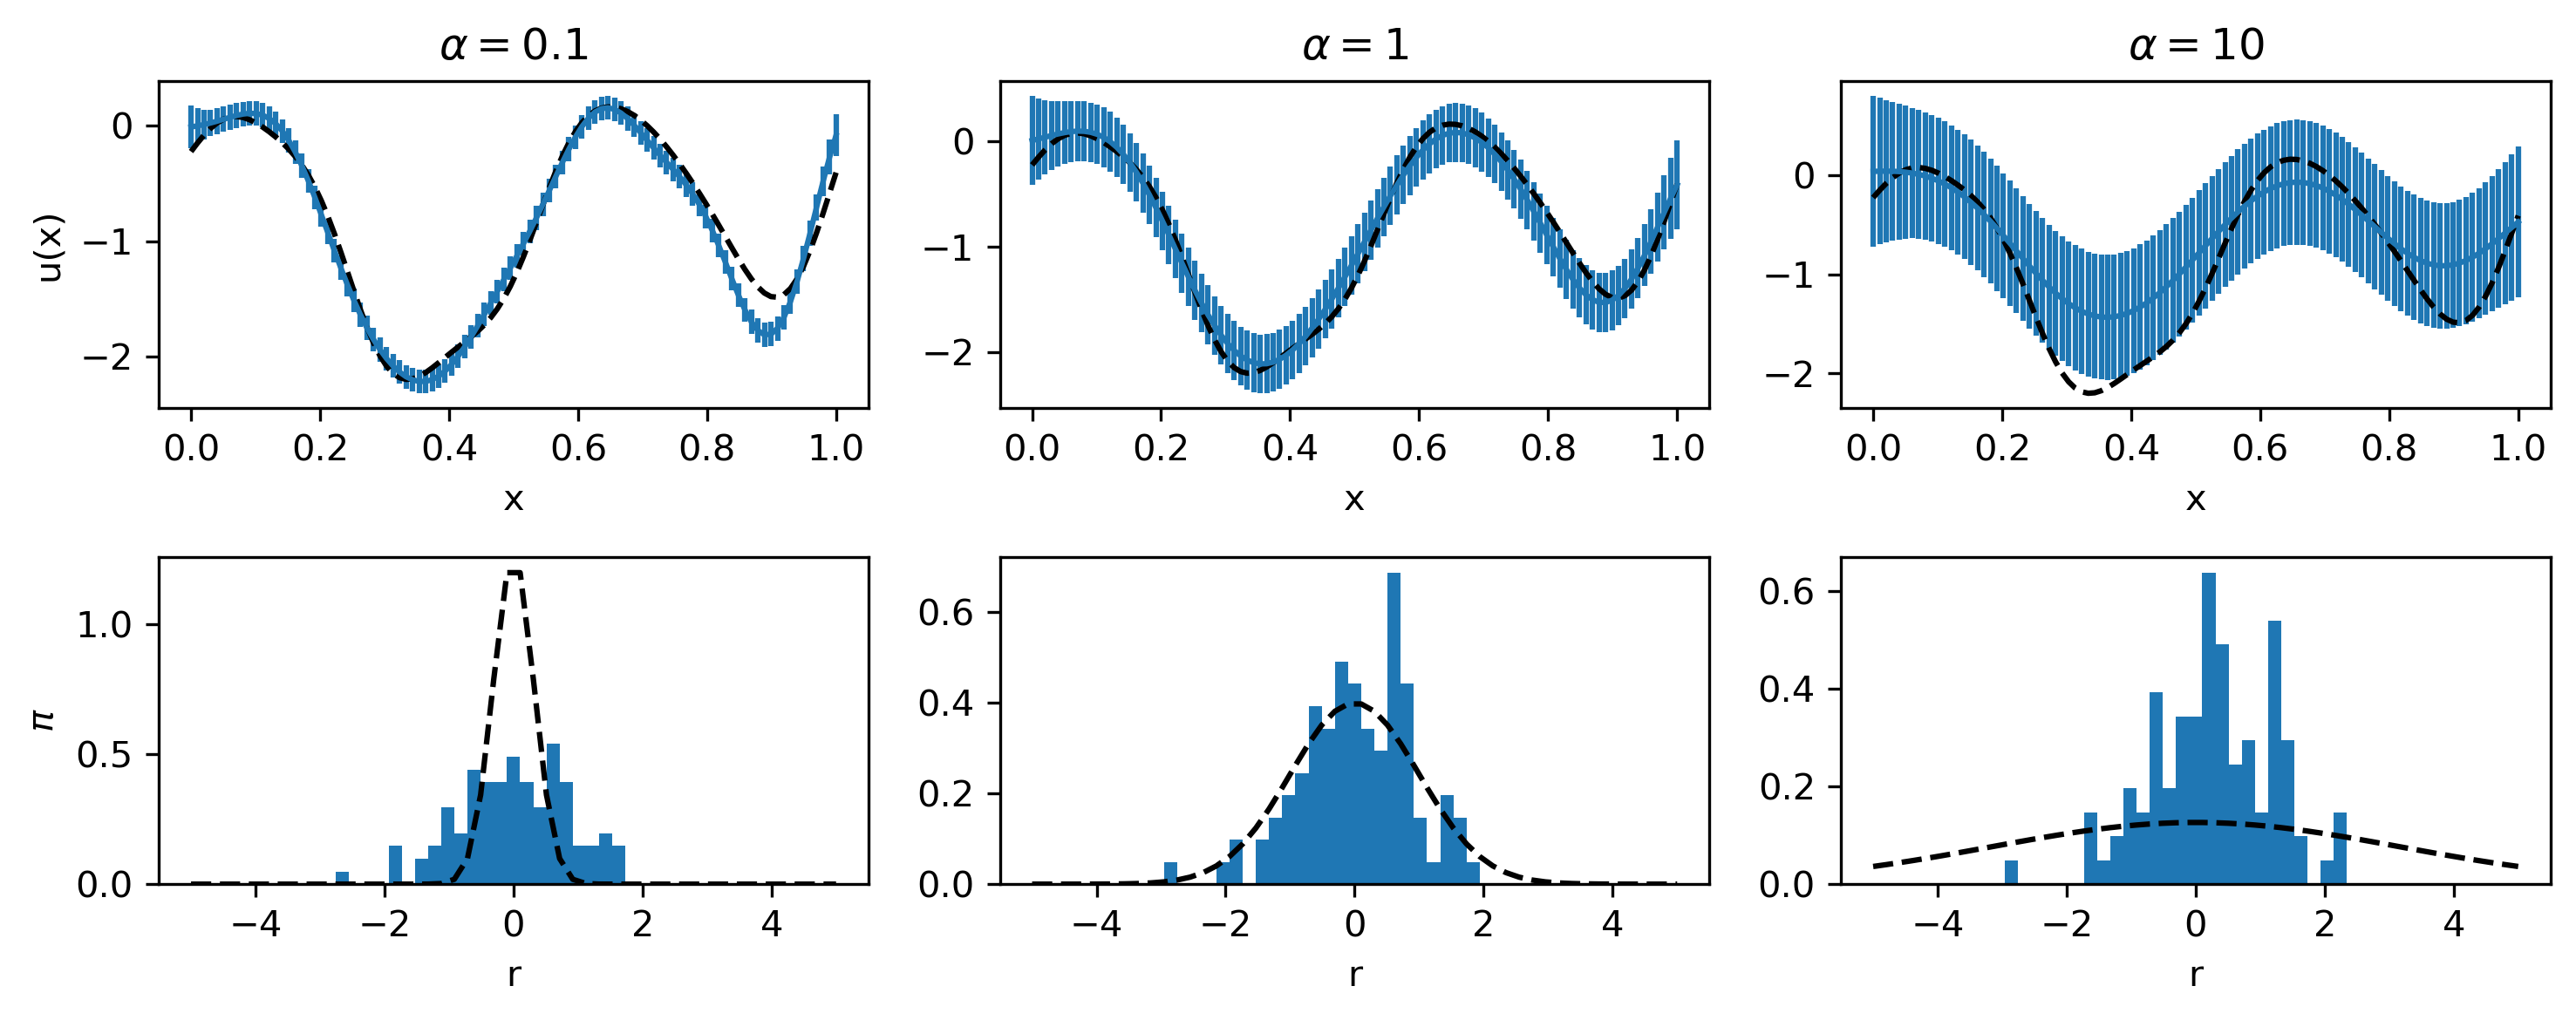

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from scipy.sparse import dia_matrix

# set random seed
np.random.seed(3)

# parameters
n = 100
sigma = 1
L = .1
alpha = [.1, 1, 10]

# grid
x = np.linspace(0,1,n)
x1,x2 = np.meshgrid(x,x)

# ground-truth and data
Sigma = np.exp(-np.abs(x1-x2)**2/(2*L**2))
u = np.random.multivariate_normal(np.zeros(n),Sigma)
f_delta = u + sigma*np.random.randn(n)

u_map = [0,0,0]
Sigma_map = [0,0,0]

for k in range(3):
    # MAP-estimate
    u_map[k] = np.linalg.solve(alpha[k]*np.eye(n) + Sigma,Sigma@f_delta)

    # covariance
    Sigma_map[k] = alpha[k]*np.linalg.inv(Sigma + alpha[k]*np.eye(n))@Sigma

# plot
r = np.linspace(-5,5,50)
fig, ax = plt.subplots(2,3)

for k in range(3):
    ax[0,k].plot(x,u,'k--',label='ground truth')
    ax[0,k].errorbar(x,u_map[k],yerr=np.sqrt(np.diag(Sigma_map[k])))
    ax[0,k].set_xlabel('x')
    ax[0,0].set_ylabel('u(x)')
    ax[0,k].set_title(r'$\alpha = $'+str(alpha[k]))

    ax[1,k].hist(u_map[k]-f_delta,bins=r,density=True)
    ax[1,k].plot(r,(1/np.sqrt(2*np.pi*alpha[k]))*np.exp(-(0.5/alpha[k])*r**2),'k--')
    ax[1,k].set_xlabel('r')
    ax[1,0].set_ylabel(r'$\pi$')

fig.set_figwidth(10)
fig.tight_layout()

plt.savefig('gaussian.png',dpi=300)

Measure a smooth signal

$$f^\delta_i = u(x_i) + \epsilon_i,\quad i \in \{0,1,\ldots, n-1\},$$

where $\epsilon_i \sim N(0,\sigma^2)$ and $u(x_i) \sim N(0,\Sigma)$, with

$$\Sigma_{ij} = \exp\left(-\frac{|i-j|^2}{2L^{2}}\right).$$

Estimate $u$ by solving:

$$\min_u \|u - f^\delta\|_2^2 + \alpha \|u\|_{\Sigma^{-1}}^2.$$

Here, $\alpha$ is an estimate of the variance of the noise, so ideally we have $\alpha \approx \sigma^{2}$. The corresponding posterior mean and covariance are given by

$$\mu_{\text{post}} = \left(\alpha I + \Sigma\right)^{-1}\Sigma f^\delta,$$

$$\Sigma_{\text{post}} = \alpha \left(\alpha I + \Sigma\right)^{-1}\Sigma.$$


![](gaussian.png)

# Modelling tools

How do we come up with probability distributions for the likelihood or prior?

* Hand-crafted feature models
* Classical methods: dictionary learning, k-means clustering, PCA, Gaussian Mixture Models
* Unsupervised machine learning

In [7]:
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.datasets import load_digits
        
def show_data(U,m,n):
    fig, ax = plt.subplots(m,n)
    k = 0
    for i in range(m):
        for j in range(n):
            ax[i,j].imshow(U[k,:].reshape(8,8),cmap='gray')
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            k += 1
    fig.tight_layout()

In [9]:
n_train = 100
n_test  = 50

digits  = load_digits()
U_train = digits.data[:n_train]
U_test  = digits.data[n_train:n_train+n_test]

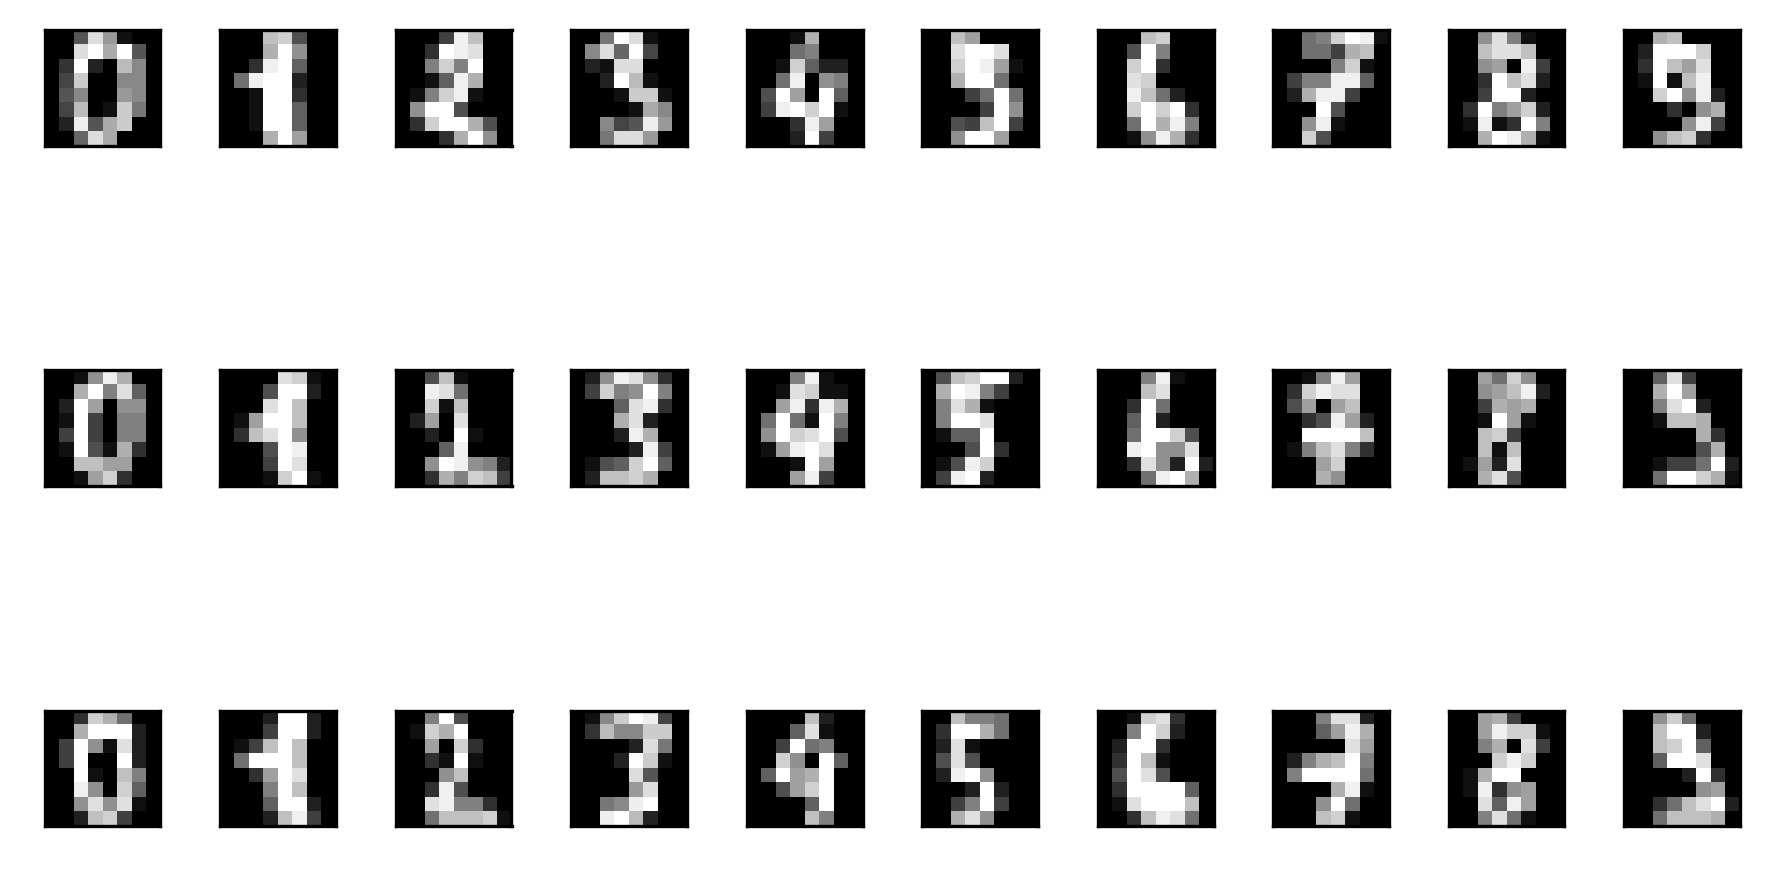

In [8]:
show_data(U_train[:30],3,10)

# Exercise

See https://github.com/TristanvanLeeuwen/Summerschool/blob/main/DictionaryLearning.ipynb